# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [401]:
import pandas as pd
import numpy as np
import math
import json
#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [402]:
import matplotlib.pyplot as plt
def plot_pie_chart(data1, data2, label1= 'Churned', label2='Not Churned'):
 # Pie chart, where the slices will be ordered and plotted counter-clockwise:
 sizes = [data1, data2]
 explode = (0, 0.1)  # only "explode" the 2nd slice - churned users
 fig1, ax1 = plt.subplots()
 ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
 ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
 plt.show()

In [403]:
print(portfolio.shape)
portfolio.head(10)

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [404]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [405]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [406]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [407]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [408]:
profile = profile.fillna(value="X")


In [409]:
profile['gender'].isna().value_counts()

False    17000
Name: gender, dtype: int64

In [410]:
profile.head()

,gender,age,id,became_member_on,income
0,X,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,X
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,X,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,X
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,X,118,a03223e636434f42ac4c3df47e8bac43,20170804,X


In [411]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            17000 non-null  object
 1   age               17000 non-null  int64 
 2   id                17000 non-null  object
 3   became_member_on  17000 non-null  int64 
 4   income            17000 non-null  object
dtypes: int64(2), object(3)
memory usage: 664.2+ KB


In [412]:
profile.describe()

,age,became_member_on
count,17000.000000,1.700000e+04
mean,62.531412,2.016703e+07
std,26.738580,1.167750e+04
min,18.000000,2.013073e+07
25%,45.000000,2.016053e+07
50%,58.000000,2.017080e+07
75%,73.000000,2.017123e+07
max,118.000000,2.018073e+07


In [413]:
profile[profile['gender'] == 'M'].describe()

,age,became_member_on
count,8484.000000,8.484000e+03
mean,52.116690,2.016675e+07
std,17.413894,1.272796e+04
min,18.000000,2.013073e+07
25%,39.000000,2.016043e+07
50%,53.000000,2.017082e+07
75%,65.000000,2.018011e+07
max,100.000000,2.018073e+07


In [414]:
profile[profile['gender'] == 'F'].describe()

,age,became_member_on
count,6129.000000,6.129000e+03
mean,57.544950,2.016704e+07
std,16.883315,1.063408e+04
min,18.000000,2.013073e+07
25%,48.000000,2.016061e+07
50%,58.000000,2.017062e+07
75%,69.000000,2.017121e+07
max,101.000000,2.018073e+07


In [415]:
profile[profile['gender'] == 'X'].describe()

,age,became_member_on
count,2175.0,2.175000e+03
mean,118.0,2.016804e+07
std,0.0,1.009105e+04
min,118.0,2.013080e+07
25%,118.0,2.016070e+07
50%,118.0,2.017073e+07
75%,118.0,2.017123e+07
max,118.0,2.018073e+07


In [416]:
profile[profile['gender'] == 'O'].describe()

,age,became_member_on
count,212.000000,2.120000e+02
mean,54.400943,2.016790e+07
std,16.244710,1.119045e+04
min,20.000000,2.013092e+07
25%,43.000000,2.016073e+07
50%,55.000000,2.017081e+07
75%,66.000000,2.018011e+07
max,100.000000,2.018072e+07


In [417]:
profile['gender'].value_counts()

M    8484
F    6129
X    2175
O     212
Name: gender, dtype: int64

In [418]:
profile[profile['gender'] == 'M'].count()

gender              8484
age                 8484
id                  8484
became_member_on    8484
income              8484
dtype: int64

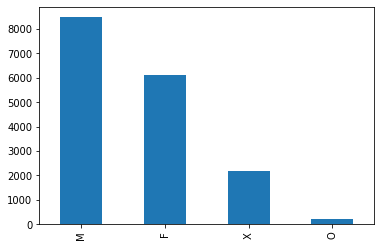

In [419]:
profile['gender'].value_counts().plot(kind="bar")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa87ea5cb50>],
      dtype=object)

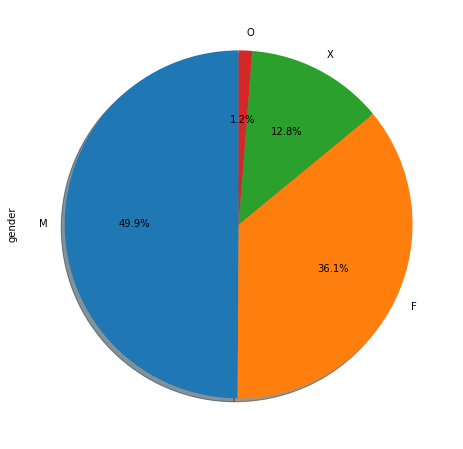

In [420]:
profile['gender'].value_counts().plot(kind='pie', subplots=True, shadow = True,startangle=90,
figsize=(8,8), autopct='%1.1f%%')

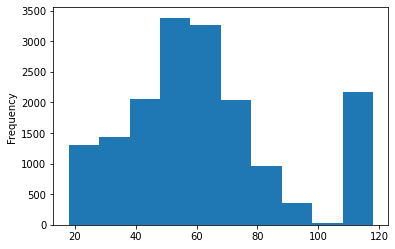

In [421]:
#Combined Age distribution of all the customers in the data set 
profile['age'].plot(kind="hist")

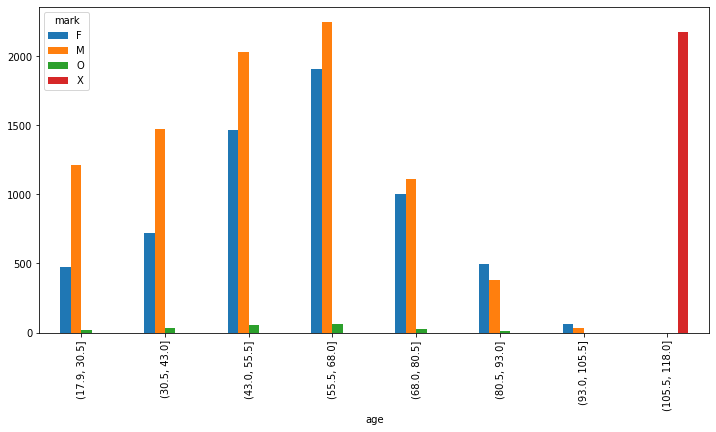

In [422]:
#MAKE AGE GROUP BINS AND PLOT DISTRIBUTION OF GENDER
age_groups = pd.cut(profile['age'], bins=8)
ct = pd.crosstab(age_groups, profile['gender'])
ct.plot.bar(stacked=False , figsize=(12,6) )
plt.legend(title='mark')

In [423]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Averag age of male customers: 52.11669024045262


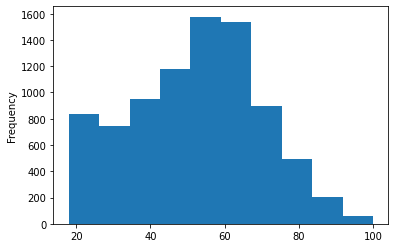

In [424]:
#AGE DISTRIBUTION AMONG MALE CUSTOMERS
gneder_grp = profile.groupby('gender')
single_grp = gneder_grp.get_group('M')
single_grp['age'].plot.hist( bins=10);
print("Averag age of male customers:", single_grp['age'].mean())

Averag age of female customers: 57.54495023658019


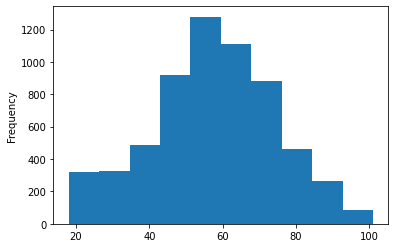

In [425]:
#AGE DISTRIBUTION AMONG FEMALE CUSTOMERS
single_grp = gneder_grp.get_group('F')
single_grp['age'].plot.hist( bins=10);
print("Averag age of female customers:", single_grp['age'].mean())

Averag age of gender neutral customers: 54.40094339622642


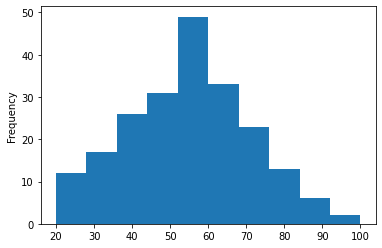

In [426]:
#AGE DISTRIBUTION AMONG GENDER NEUTRAL CUSTOMERS
single_grp = gneder_grp.get_group('O')
single_grp['age'].plot.hist( bins=10);
print("Averag age of gender neutral customers:", single_grp['age'].mean())

Averag age of no gender customers: 118.0


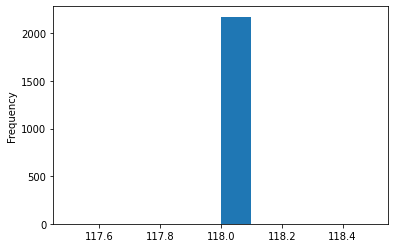

In [427]:
single_grp = gneder_grp.get_group('X')
single_grp['age'].plot.hist( bins=10);
print("Averag age of no gender customers:", single_grp['age'].mean())

In [428]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [429]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [430]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [431]:
#TURN DICTIONARY IN TRANSCRIPT TO DATAFRAME
from pandas.io.json import json_normalize
new_df = json_normalize(transcript.value)
new_df = new_df.fillna('0')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [432]:
new_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0
2,2906b810c7d4411798c6938adc9daaa5,0,0,0
3,fafdcd668e3743c1bb461111dcafc2a4,0,0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0


In [433]:
import numpy as np
new_df['offer'] = np.where(new_df['offer id'] == '0',new_df['offer_id'], new_df['offer id'])

In [434]:
new_df.head()

,offer id,amount,offer_id,reward,offer
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2906b810c7d4411798c6938adc9daaa5,0,0,0,2906b810c7d4411798c6938adc9daaa5
3,fafdcd668e3743c1bb461111dcafc2a4,0,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [435]:
sub_df = new_df[['amount' , 'offer' , 'reward']]
sub_df.head()

,amount,offer,reward
0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,0,2906b810c7d4411798c6938adc9daaa5,0
3,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [436]:
merged_df = pd.concat([transcript ,sub_df], axis=1)

In [437]:
merged_df.head()

,person,event,value,time,amount,offer,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [438]:
merged_df = merged_df.drop(columns=['value'])

In [439]:
merged_df.head()

,person,event,time,amount,offer,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [440]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   time    306534 non-null  int64 
 3   amount  306534 non-null  object
 4   offer   306534 non-null  object
 5   reward  306534 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.0+ MB


In [441]:
merged_df = merged_df.merge(profile, left_on='person', right_on='id')

In [442]:
merged_df.shape

(306534, 11)

In [443]:
merged_df.columns

Index(['person', 'event', 'time', 'amount', 'offer', 'reward', 'gender', 'age',
       'id', 'became_member_on', 'income'],
      dtype='object')

In [444]:
merged_df = merged_df.drop(columns = ['id'])

In [445]:
merged_df.head()

,person,event,time,amount,offer,reward,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,0,0,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,0,0,F,75,20170509,100000.0


In [446]:
merged_df = merged_df.merge(portfolio, left_on='offer', right_on='id', how = 'left')
merged_df = merged_df.drop(columns = ['id', 'reward_y','offer'])
merged_df.head()

,person,event,time,amount,reward_x,gender,age,became_member_on,income,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,0,F,75,20170509,100000.0,"[web, email, mobile]",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,F,75,20170509,100000.0,"[web, email, mobile]",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,0,F,75,20170509,100000.0,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,0,5.0,F,75,20170509,100000.0,"[web, email, mobile]",5.0,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,0,F,75,20170509,100000.0,NaN,NaN,NaN,NaN


In [447]:
merged_df[merged_df['gender'] == 'F']['event'].value_counts()

transaction        49382
offer received     27456
offer viewed       20786
offer completed    15477
Name: event, dtype: int64

In [448]:
merged_df.fillna(0)

,person,event,time,amount,reward_x,gender,age,became_member_on,income,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,0,F,75,20170509,100000.0,"[web, email, mobile]",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,0,0,F,75,20170509,100000.0,"[web, email, mobile]",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,0,F,75,20170509,100000.0,0,0.0,0.0,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,0,5.0,F,75,20170509,100000.0,"[web, email, mobile]",5.0,7.0,bogo
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,0,F,75,20170509,100000.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,0,0,X,118,20170926,X,"[web, email, mobile, social]",10.0,5.0,bogo
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,594,0,0,X,118,20170926,X,"[web, email, mobile, social]",10.0,5.0,bogo
306531,3045af4e98794a04a5542d3eac939b1f,offer received,576,0,0,F,58,20161020,78000.0,"[web, email, mobile, social]",10.0,5.0,bogo
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,576,0,0,F,58,20161020,78000.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [449]:
merged_df.groupby(["offer_type" , "gender"]).count()

person  event   time  amount  reward_x    age  \
offer_type    gender                                                  
bogo          F        27619  27619  27619   27619     27619  27619   
              M        35301  35301  35301   35301     35301  35301   
              O          914    914    914     914       914    914   
              X         7783   7783   7783    7783      7783   7783   
discount      F        26652  26652  26652   26652     26652  26652   
              M        34739  34739  34739   34739     34739  34739   
              O          920    920    920     920       920    920   
              X         7587   7587   7587    7587      7587   7587   
informational F         9448   9448   9448    9448      9448   9448   
              M        12856  12856  12856   12856     12856  12856   
              O          356    356    356     356       356    356   
              X         3406   3406   3406    3406      3406   3406   

                      became_member_on  income  channels  difficulty  duration  
offer_type    gender                                                            
bogo          F                  27619   27619     27619       27619     27619  
              M                  35301   35301     35301       35301     35301  
              O                    914     914       914         914       914  
              X                   7783    7783      7783        7783      7783  
discount      F                  26652   26652     26652       26652     26652  
              M                  34739   34739     34739       34739     34739  
              O                    920     920       920         920       920  
              X                   7587    7587      7587        7587      7587  
informational F                   9448    9448      9448        9448      9448  
              M                  12856   12856     12856       12856     12856  
              O                    356     356       356         356       356  
              X                   3406    3406      3406        3406      3406

In [450]:
merged_df.groupby(["offer_type"])["gender"].value_counts()

offer_type     gender
bogo           M         35301
               F         27619
               X          7783
               O           914
discount       M         34739
               F         26652
               X          7587
               O           920
informational  M         12856
               F          9448
               X          3406
               O           356
Name: gender, dtype: int64

In [451]:
merged_df.groupby(["gender"])

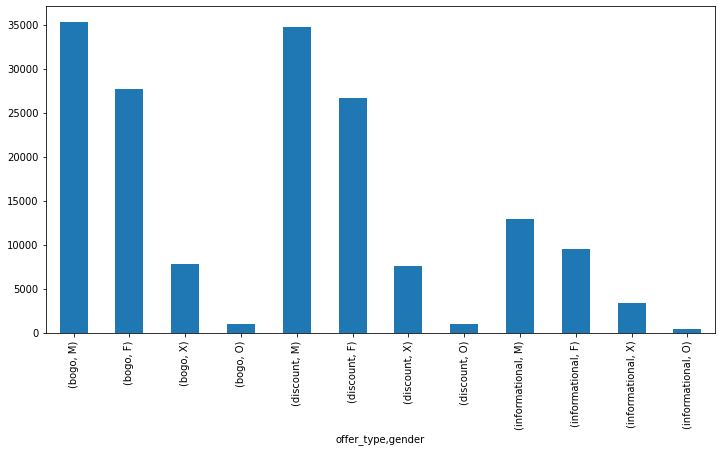

In [452]:
#OFFER TYPES SEND TO ALL GENDERS
merged_df.groupby(["offer_type"])['gender'].value_counts().plot(kind ='bar' , figsize = (12,6))

In [453]:
def plot_offertyp_with_age_distribution(sex):
 """
  PLOT THE OFFERTYPE SENT TO CUSTOMERS
  BASED ON AGE DISTRIBUTION
 """
 grp = merged_df.groupby(["gender"])
 sel_sex = grp.get_group(sex)
 ct = pd.crosstab(age_groups, sel_sex['offer_type'])
 ct.plot.bar(stacked=False , figsize=(12,6) )
 plt.legend(title='mark')

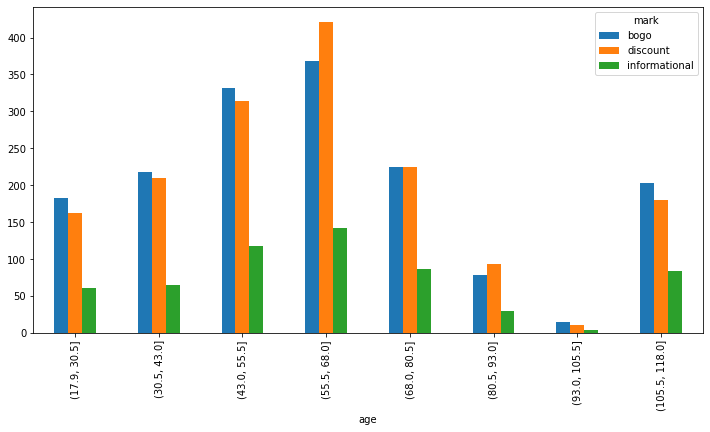

In [454]:
plot_offertyp_with_age_distribution("F")

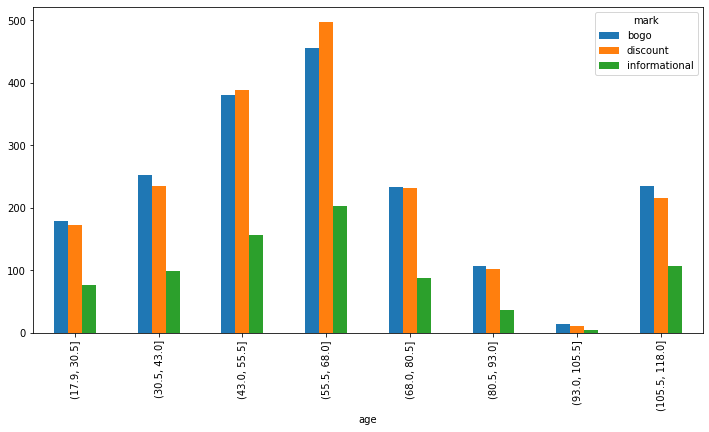

In [455]:
plot_offertyp_with_age_distribution("M")

In [459]:
x = merged_df.groupby(['person'], sort = True)

In [460]:
#SEQ USED TO DETERMINE THE INF FEATURE
seq1 = ['offer received' ,'offer viewed' , 'offer completed']


def list_in(a, b):
  """
  FIND THE GIVEN SEQUENCE IN THE LIST
  """
 return any(map(lambda x: b[x:x + len(a)] == a, range(len(b) - len(a) + 1)))

In [461]:
result = {}
for name, group in x:
  cc = group[group['offer_type'] != 'informational']['event'].tolist()
  a = [x for x in cc if x != 'transaction']
  result[name] = list_in(seq1 , a)

In [462]:
fb = pd.DataFrame(result.items(), columns=['id', 'inf'])

In [463]:
fb[fb['id']== '0011e0d4e6b944f998e987f904e8c1e5']
fb.columns
fb.head()

,id,inf
0,0009655768c64bdeb2e877511632db8f,False
1,00116118485d4dfda04fdbaba9a87b5c,False
2,0011e0d4e6b944f998e987f904e8c1e5,True
3,0020c2b971eb4e9188eac86d93036a77,True
4,0020ccbbb6d84e358d3414a3ff76cffd,True


In [464]:
tmp = profile
tmp.head()

,gender,age,id,became_member_on,income
0,X,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,X
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,X,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,X
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,X,118,a03223e636434f42ac4c3df47e8bac43,20170804,X


In [465]:
inf_df = pd.merge(tmp, fb , on = 'id')
inf_df.head()
inf_df['inf'].value_counts()

True     11196
False     5804
Name: inf, dtype: int64

In [466]:
inf_df.head()

,gender,age,id,became_member_on,income,inf
0,X,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,X,True
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,False
2,X,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,X,False
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,True
4,X,118,a03223e636434f42ac4c3df47e8bac43,20170804,X,False


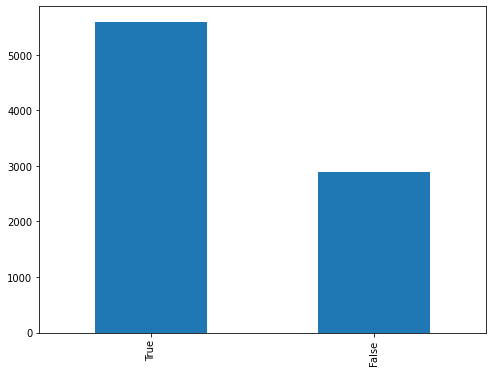

In [467]:
gender = inf_df.groupby(["gender"])
gender_grp = gender.get_group("M")
gender_grp['inf'].value_counts().plot(kind ='bar' , figsize = (8,6))

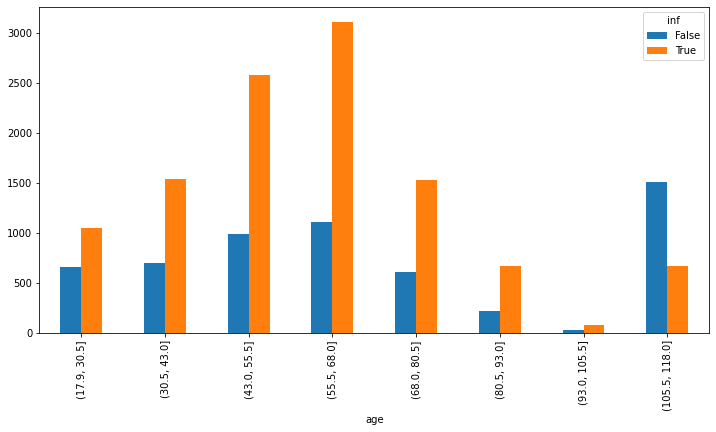

In [468]:
ct_inf = pd.crosstab(age_groups, inf_df['inf'])
ct_inf.plot.bar(stacked=False , figsize=(12,6) )

In [469]:
def plot_offer_influence(sex):
  """
  PLOTS THE INFLUENCE OF MARKETING OFFERS BASED ON 
  CUSTOMRE GENDER
  """
  gender = inf_df.groupby(["gender"])
  gender_grp = gender.get_group(sex)
  ct_inf = pd.crosstab(age_groups, gender_grp['inf'])
  ct_inf.plot.bar(stacked=False , figsize=(12,6) )

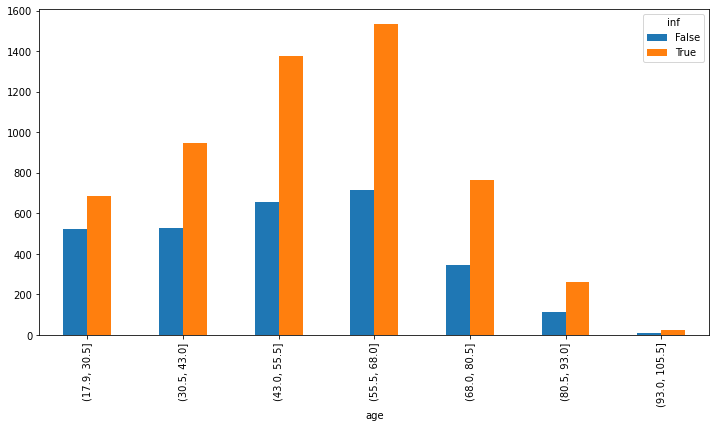

In [470]:
plot_offer_influence("M")

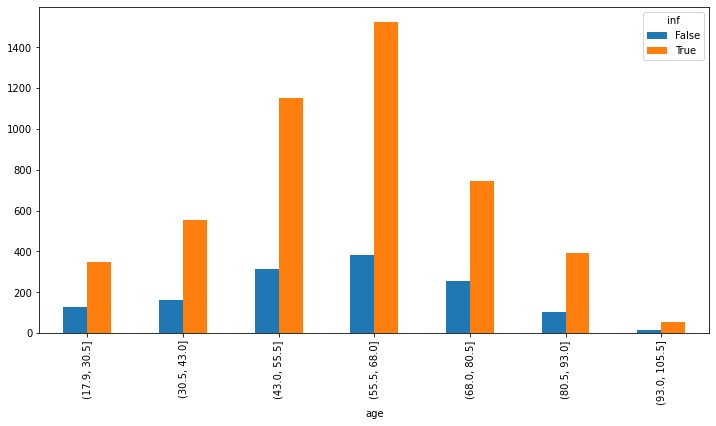

In [471]:
plot_offer_influence("F")

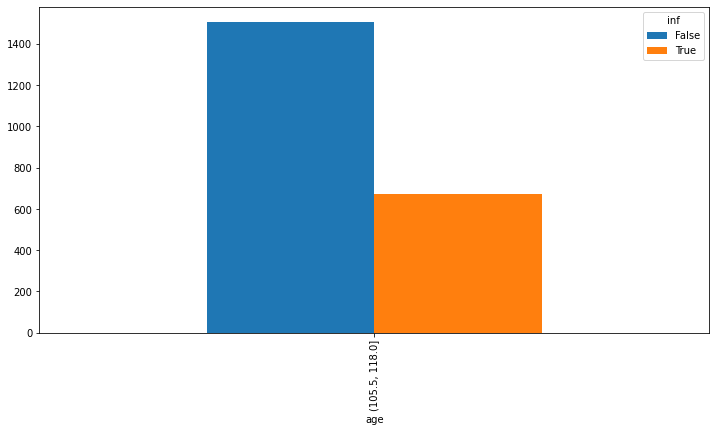

In [472]:
plot_offer_influence("X")

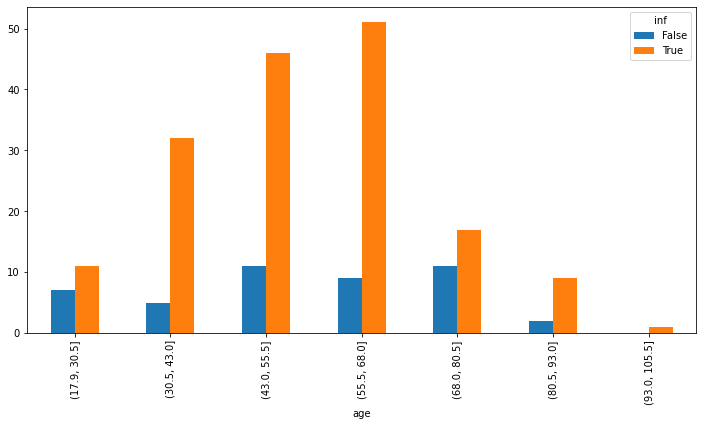

In [473]:
plot_offer_influence("O")